## 1.- Import standard libraries

In [1]:
# Import custom libraries from local folder.
from importlib import reload
import sys
sys.path.append("..")

# Import nn module from torch to replicate kessler tool
import torch.nn as nn

# Import utils library containing miscellaneous functions/classes
from scalib import utils

# Import library to import Kelvins challlenge data
from scalib.eda import kelvins_challenge_events

# Import SCALIB modules for NN development
import scalib.nn as snn             # NN models
import scalib.cells as cell         # RNN cell architectures

# Import kessler RNN model
import scalib.kessler as kessler

# Set overall seed for reproducibility
utils.seed(1)

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rc

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in utils.cwd:
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)

print(utils.cwd)

/Users/jjrr/Documents/SCA-Project/scalib


## 2.- Data preparation

In [2]:
#As an example, we first show the case in which the data comes from the Kelvins competition.
#For this, we built a specific converter that takes care of the conversion from Kelvins format
#to standard CDM format (the data can be downloaded at https://kelvins.esa.int/collision-avoidance-challenge/data/):
filepath = utils.os.path.join(utils.cwd,'data','esa-challenge','train_data.csv')

# Get ConjunctionEventsDataset object 
events = kelvins_challenge_events(filepath,
            drop_features = ['c_rcs_estimate', 't_rcs_estimate'], 
            num_events = 500)

# Get features to train the model.
nn_features = events.common_features(only_numeric=True)

# Define input and output size of the RNN model.
input_size = len(nn_features)
output_size = len(nn_features)

# Split data into a test set (5% of the total number of events)
len_test_set=int(0.05*len(events))

# Get Events to test model: used to compute the error the model would have in 
# run-mode.
events_test=events[-len_test_set:]
print('\nTest data:', events_test)

# Get events used for training and validation:
# - Training set: Used to train the model and backpropagate the loss.
# - Validation set: Used to compute the loss so that hyperparameters can be 
#   adjusted.
events_train_and_val=events[:-len_test_set]
print('Training and validation data:', events_train_and_val)

Kelvins Challenge dataset imported from external file (162634 entries):
/Users/jjrr/Documents/SCA-Project/scalib/data/esa-challenge/train_data.csv

KELVINS DATASET IMPORT:
| Progress                   |    Time     | Iters/sec | Comments
| 100% |██████████| (500/500)| 00h:00m:02s |  189.24   | Dataset imported (500 events).          

CONJUNCTION EVENTS DATASET -> PANDAS DATAFRAME:
| Progress                   |    Time     | Iters/sec | Comments
| 100% |██████████| (500/500)| 00h:00m:07s |   63.04   | Pandas DataFrame saved.                                 

Test data: ConjunctionEventsDataset(Events:25 | Number of CDMs per event: 3 (min), 22 (max), 14.52 (mean))
Training and validation data: ConjunctionEventsDataset(Events:475 | Number of CDMs per event: 1 (min), 22 (max), 13.82 (mean))


## 3.- Recurrent Neural Network model configuration

### 3.1.- RNN layer and cell architecture definition

In [3]:
# Initialize dictionary of pytorch modules
networks = nn.ModuleDict({})

# Initialize parameters
num_layers = 2      # Number of stacked LSTM layers
dropout = 0.2       # Dropout probability between layers
hidden_size = 256   # Hidden size

In [4]:
# Initialize LSTM architecture using custom cell
layers = nn.ModuleDict({'lstm': nn.LSTM(input_size = input_size,
                                        batch_first = True,
                                        hidden_size = hidden_size,
                                        num_layers = num_layers,
                                        dropout = dropout)})
networks.update({'kessler':layers})

#### 3.1.2.- LSTM layer with *Vanilla* cell architecture ([Kessler](https://github.com/kesslerlib/kessler.git)'s configuration)

In [5]:
# Initialize LSTM architecture using custom cell
layers = nn.ModuleDict({'lstm': snn.LSTM(input_size = input_size,
                                         batch_first = True, 
                                         hidden_size = hidden_size, 
                                         num_layers = num_layers,
                                         dropout = dropout,
                                         cell = cell.LSTM_Vanilla)})
networks.update({'vanilla':layers})

#### 3.1.3.- LSTM layer with *SLIMX* cell architecture (*x* = 1, 2, or 3)

In [6]:
# Initialize LSTM architecture using SLIMx cell architecture. 
# Three options are available by passing the extra parameter slim_version
# 1 - Gates contain hidden states weights and bias (Wh + b). Default value.
# 2 - Gates contain hidden states weights only (Wh).
# 3 - Gates contain learnable bias only (b).
for v in [1, 2, 3]:
    cell_args = dict(slim_version = v)
    layers = nn.ModuleDict({'lstm': snn.LSTM(input_size = input_size, 
                                            hidden_size = hidden_size,
                                            cell = cell.LSTM_SLIMX, 
                                            num_layers = num_layers,
                                            dropout = dropout,
                                            **cell_args)})
    networks.update({f'slim{v}':layers})

#### 3.1.4.- LSTM layer with no *X* gate (NXG) in cell architecture (*X* = Input, Forget or Output)

In [7]:
# Initialize LSTM architecture using NXG cell architecture (one of the 
# information gates within the cell is cancelled out. 
for gate in ['input', 'output', 'forget']:
    cell_args = dict(drop_gate = gate)
    layers = nn.ModuleDict({'lstm': snn.LSTM(input_size = input_size, 
                                            hidden_size = hidden_size,
                                            cell = cell.LSTM_NXG, 
                                            num_layers = num_layers,
                                            dropout = dropout,
                                            **cell_args)})
    networks.update({f'n{gate[0]}g':layers})

#### 3.1.5.- LSTM layer with no activation function at *X* gate (NXGAF) in cell architecture (*X* = Input, Forget, Output, or Cell)

In [8]:
# Initialize LSTM architecture using NXG cell architecture (one of the 
# information gates within the cell is cancelled out. 
for gate in ['input', 'output', 'forget', 'cell']:
    cell_args = dict(naf_gate = gate)
    layers = nn.ModuleDict({'lstm': snn.LSTM(input_size = input_size, 
                                            hidden_size = hidden_size,
                                            cell = cell.LSTM_NXGAF, 
                                            num_layers = num_layers,
                                            dropout = dropout,
                                            **cell_args)})
    networks.update({f'n{gate[0]}gaf':layers})

#### 3.1.6.- LSTM-Attention-LSTM layer

In [9]:
# Initialize encoder
encoder = snn.LSTM(input_size = input_size, 
                   hidden_size = hidden_size,
                   cell = cell.LSTM_Vanilla)

# Get the SelfAttention layer (SelfAttention)
attention = snn.SelfAttentionLayer(input_size = encoder.hidden_size,
                                   num_heads = 2)

# Initialize decoder
decoder = snn.LSTM(input_size = encoder.hidden_size, 
                   hidden_size = encoder.hidden_size,
                   cell = cell.LSTM_Vanilla)



layers = nn.ModuleDict({'lstm_encoder': encoder,
                        'attention': attention,
                        'lstm_decoder': decoder})

networks.update({f'attention':layers})

# # print(layers)

### 3.2.- Model instanciation

In [10]:
# Print number of parameters per model
print('{:^12} | {:>12}\n{}'.format('Network','Parameters', '-'*30))
for network_name, layers in networks.items():
    
    # Add remaining parameters for the model instanciation.
    layers.update({'dropout': nn.Dropout(p = dropout),
                'relu': nn.ReLU(),
                'linear': nn.Linear(hidden_size, output_size)})

    # Get number of parameters in the model.
    num_params = sum(p.numel() for p in layers.parameters())

    print('{:^12} | {:>12,}'.format(network_name.upper(),num_params))

  Network    |   Parameters
------------------------------
  KESSLER    |      875,074
  VANILLA    |      875,074
   SLIM1     |      625,730
   SLIM2     |      624,194
   SLIM3     |      232,514
    NIG      |      660,546
    NOG      |      660,546
    NFG      |      660,546
   NIGAF     |      875,074
   NOGAF     |      875,074
   NFGAF     |      875,074
   NCGAF     |      875,074
 ATTENTION   |    1,138,242


In [11]:
# Print model.
layers = networks['slim2']
print(f'\n{layers}\n')

# Initialize model.
model = snn.ConjunctionEventForecaster(layers = layers, features = nn_features)


ModuleDict(
  (lstm): LSTM(
    (layers): ModuleList(
      (0): LSTMLayer(
        (cell): LSTM_SLIMX(
          (_sigmoid): Sigmoid()
          (_tanh): Tanh()
          (gate_forget_h): Linear(in_features=256, out_features=256, bias=False)
          (gate_input_h): Linear(in_features=256, out_features=256, bias=False)
          (gate_cell_x): Linear(in_features=66, out_features=256, bias=True)
          (gate_cell_h): Linear(in_features=256, out_features=256, bias=False)
          (gate_output_h): Linear(in_features=256, out_features=256, bias=False)
        )
      )
      (1): LSTMLayer(
        (cell): LSTM_SLIMX(
          (_sigmoid): Sigmoid()
          (_tanh): Tanh()
          (gate_forget_h): Linear(in_features=256, out_features=256, bias=False)
          (gate_input_h): Linear(in_features=256, out_features=256, bias=False)
          (gate_cell_x): Linear(in_features=256, out_features=256, bias=True)
          (gate_cell_h): Linear(in_features=256, out_features=256, bias=Fa

### Model training

In [12]:
# Start training
model.learn(events_train_and_val, epochs = 20, lr = 1e-3, batch_size = 16, 
            device = 'cpu', valid_proportion = 0.15, num_workers = 4,
            event_samples_for_stats = 1000)

Number of learnable parameters of the model: 624,194

CONJUNCTION EVENTS DATASET -> PANDAS DATAFRAME:
| Progress                   |    Time     | Iters/sec | Comments
| 100% |██████████| (475/475)| 00h:00m:00s | 122897.69 | Pandas DataFrame saved.                                 

FORECASTING MODEL TRAINING:
| Progress                   |    Time     | Iters/sec | Comments
| 100% |██████████| (500/500)| 00h:14m:36s |   0.57    | Batch 25/25 | Loss -> Train = 1.1708e-01 : Valid = 2.8170e-01


##### Training vs validation loss

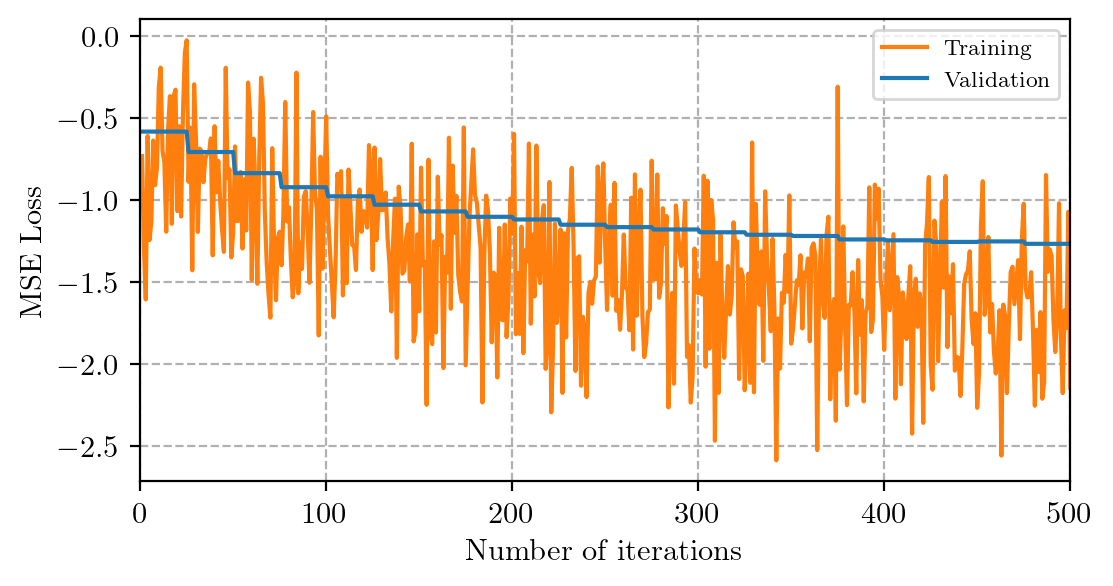

In [14]:
# Plot MSE loss throughout iterations.
model.plot_loss(filepath = None, log_scale = True)

##### Conjunction event forecasting

In [ ]:
# Take a single event from test dataset and remove the last CDM.
event_idx = 2
event = events_test[event_idx]
event_beginning = event[0:len(event)-1]

# Print information about the event to forecast.
print(f'Forecasting next CDM from previous {len(event)} CDM(s)...')

# Predict the evolution of the conjunction event until TCA or the number of CDMs
# is max_length.
event_evolution = model.predict_event(event = event_beginning, 
                                      num_samples = 10, 
                                      max_length = 14)

# List of features to predict.
features = ['RELATIVE_SPEED', 'MISS_DISTANCE', 'OBJECT1_CT_T']

# Plot prediction in red
axs = event_evolution.plot_features(features = features, return_axs = True, 
                                    linewidth = 0.1, color = 'red', alpha=0.33, 
                                    label = 'Prediction')
#and the ground truth value in blue:
event.plot_features(features=features, axs=axs, label='Actual', legend = True)